In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [3]:
ts, dt = (10.0, 0.1)
def simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x, v = 0, 5  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    return torch.tensor(trajectory)

In [4]:
true_parameter = torch.tensor([10, 5.0, 2.0])
x_observed = simulator(true_parameter)

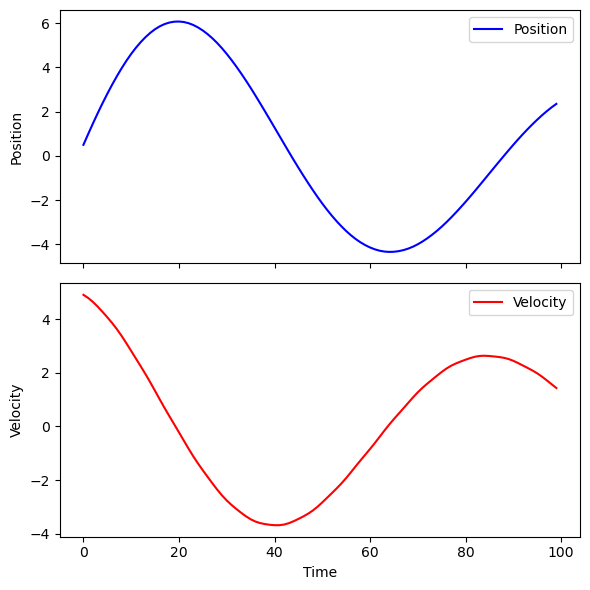

In [5]:
t = torch.arange(len(x_observed))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Position", color="b")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Velocity", color="r")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [6]:
prior = BoxUniform(low=torch.tensor([5.0, 2.0, 0.5]), 
                   high=torch.tensor([15.0, 8.0, 5.0]))

prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [7]:
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [9]:
num_simulations = 10000

In [10]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.fc(h[:, -1, :])  # Use last hidden state for prediction
        return out

In [10]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [11]:
# inference = NPE(prior=prior, density_estimator=neural_posterior)
inference = NPE(prior=prior)

In [14]:
summary_stats_x = torch.stack([compute_summary_statistics(xi) for xi in x])

In [15]:
summary_stats_x[0]

tensor([ 4.9174e+00,  4.8291e+00,  5.8820e+00,  3.7838e+00,  2.2825e-01,
         1.5034e-01, -1.1466e+00, -5.0842e-01,  1.7000e+00,  1.2327e+00,
         2.0000e-02,  1.0265e+02,  1.0000e-01,  1.6280e+02])

In [16]:
# Flatten the input tensor x
density_estimator = inference.append_simulations(theta, summary_stats_x).train()

 Neural network successfully converged after 342 epochs.

In [17]:
posterior = inference.build_posterior(density_estimator)

In [18]:
import pickle
with open(f"./models/my_posterior_{num_simulations}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [19]:
samples = posterior.sample((5000,), x=compute_summary_statistics(x_observed))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

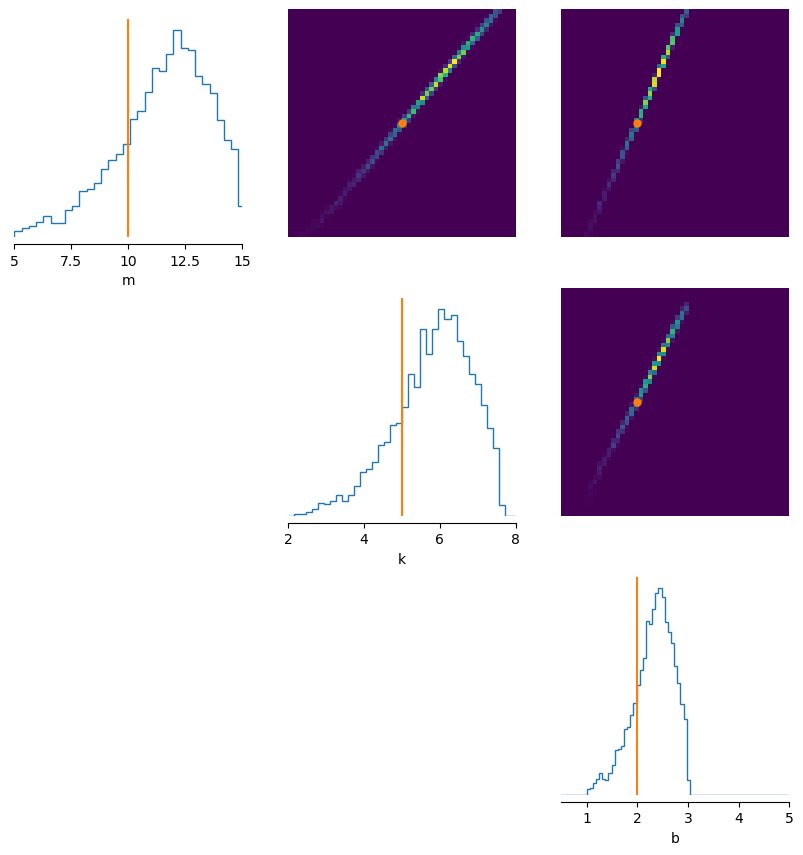

In [20]:
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter.unsqueeze(0),
    labels=["m", "k", "b"],
    limits=[[5, 15], [2.0, 8.0], [0.5, 5.0]]
)

In [21]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=compute_summary_statistics(x_observed)).numpy()
posterior_min = np.array([[6.5,   2,  0.5]])
posterior_max = np.array([[8.5,   4,  2.5]])
x_min = mass_spring_damper_fixed_simulator(posterior_min.squeeze())
x_max = mass_spring_damper_fixed_simulator(posterior_max.squeeze())
x_posterior = mass_spring_damper_fixed_simulator(posterior_sample.squeeze())
print(posterior_sample)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[11.638279   5.80835    2.3169692]]


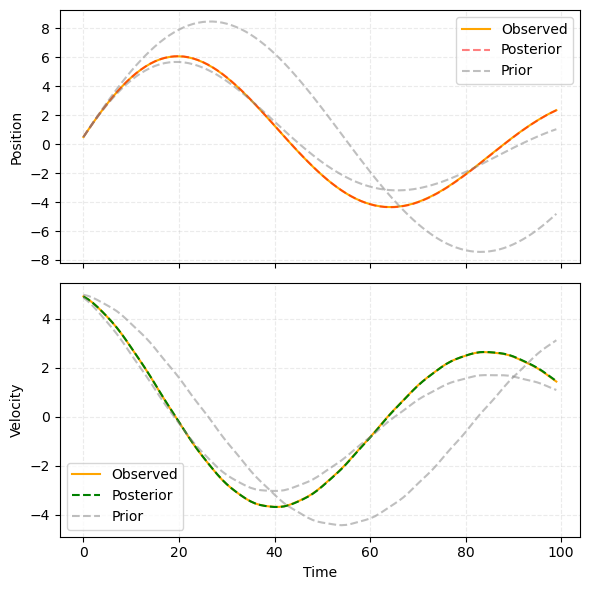

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Observed",color="orange")
axes[0].plot(t, x_posterior[:, 0], label="Posterior", linestyle='--' ,color="red", alpha=0.5)
axes[0].plot(t, x_min[:, 0], label="Prior", linestyle='--' ,color="grey", alpha=0.5)
axes[0].plot(t, x_max[:, 0], linestyle='--' ,color="grey", alpha=0.5)
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Observed", color="orange")
axes[1].plot(t, x_posterior[:, 1], label="Posterior", linestyle='--', color="green")
axes[1].plot(t, x_min[:, 1], label="Prior", linestyle='--', color="grey", alpha=0.5)
axes[1].plot(t, x_max[:, 1], linestyle='--', color="grey", alpha=0.5)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()

In [23]:
# Test
test_theta = posterior.sample((1,), x=compute_summary_statistics(x_observed)).numpy()
test_theta

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

array([[8.828139 , 4.4347544, 1.7712325]], dtype=float32)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

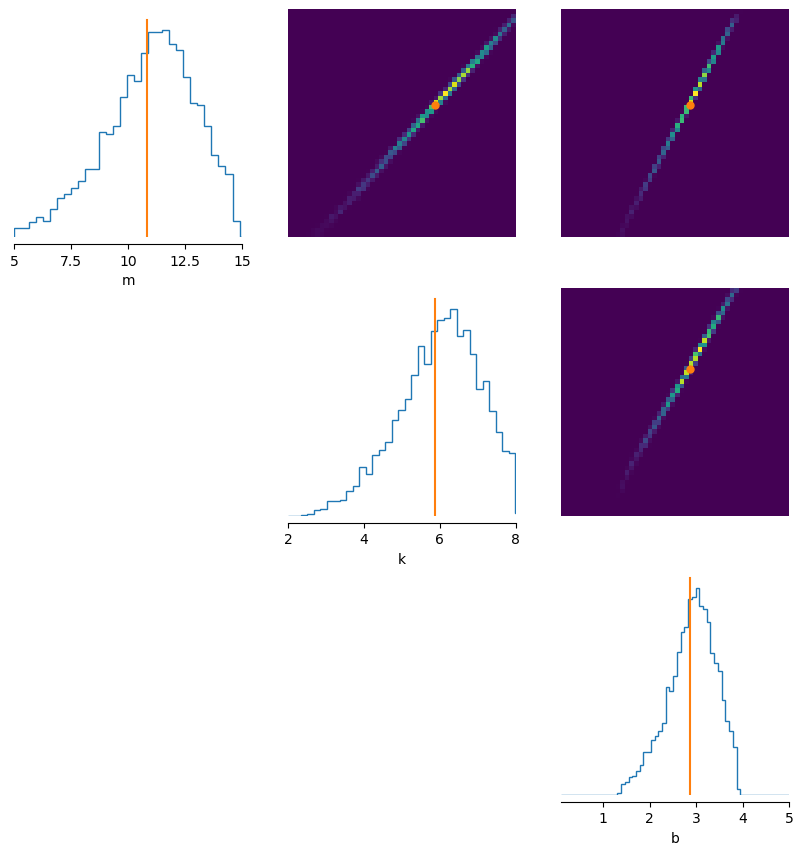

In [24]:
test_theta = prior.sample((1,))
test_x = mass_spring_damper_fixed_simulator(test_theta.squeeze())
test_samples = posterior.sample((5000,), x=compute_summary_statistics(test_x))
fig, ax = analysis.pairplot(
    test_samples,
    points=test_theta,
    labels=["m", "k", "b"],
    limits=[[5, 15], [2.0, 8.0], [0.1, 5.0]]
)

In [25]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=compute_summary_statistics(test_x)).numpy()
posterior_min = np.array([[9.5,   2,  0.5]])
posterior_max = np.array([[11.5,   4,  2.5]])
x_min = mass_spring_damper_fixed_simulator(posterior_min.squeeze())
x_max = mass_spring_damper_fixed_simulator(posterior_max.squeeze())
x_posterior = mass_spring_damper_fixed_simulator(posterior_sample.squeeze())
print(posterior_sample)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[12.954842   7.088226   3.4043896]]


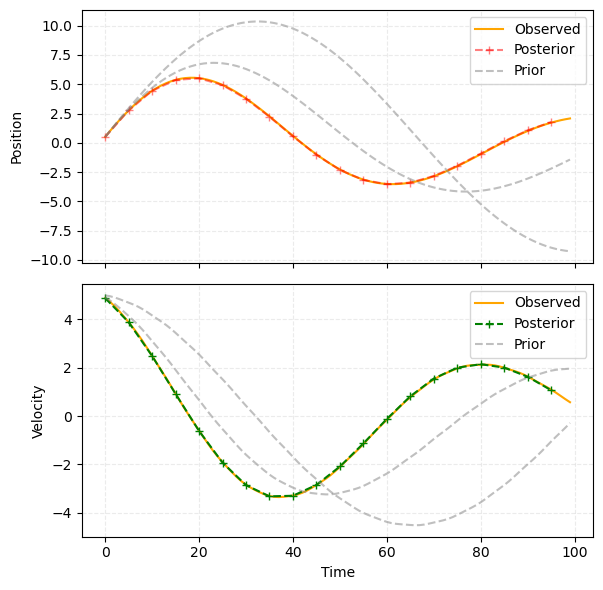

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, test_x[:, 0], label="Observed",color="orange")
axes[0].plot(t[::5], x_posterior[::5, 0], '+', label="Posterior", linestyle='--' ,color="red", alpha=0.5)
axes[0].plot(t, x_min[:, 0], label="Prior", linestyle='--' ,color="grey", alpha=0.5)
axes[0].plot(t, x_max[:, 0], linestyle='--' ,color="grey", alpha=0.5)
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

# Plot second column
axes[1].plot(t, test_x[:, 1], label="Observed", color="orange")
axes[1].plot(t[::5], x_posterior[::5, 1], '+', label="Posterior", linestyle='--', color="green")
axes[1].plot(t, x_min[:, 1], label="Prior", linestyle='--', color="grey", alpha=0.5)
axes[1].plot(t, x_max[:, 1], linestyle='--', color="grey", alpha=0.5)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()

In [27]:
theta_posterior = posterior.sample((100,), x=compute_summary_statistics(x_observed))

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
x_predictive = torch.stack([mass_spring_damper_fixed_simulator(theta) for theta in theta_posterior])

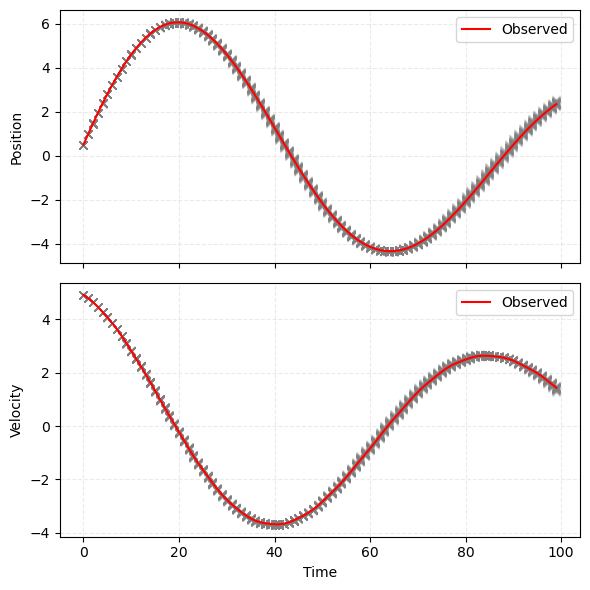

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Plot predictive trajectories in grey
for x_pred in x_predictive:
    axes[0].plot(t, x_pred[:, 0], 'x', color='grey', alpha=0.1)
    axes[1].plot(t, x_pred[:, 1], 'x', color='grey', alpha=0.1)

# Plot observed trajectory in red
axes[0].plot(t, x_observed[:, 0], label="Observed", color="red")
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

axes[1].plot(t, x_observed[:, 1], label="Observed", color="red")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()